In [1]:
# ============================================================
# AE-only Cross-Dataset Detector (Binary: Benign vs Attack)
# - Trains AE on benign-only sequences from train dataset.
# - Uses reconstruction error + threshold to detect Attack.
# - Per-day reports include overall binary and per-attack (DoS/DDoS) binary
#   metrics, each with attack-specific thresholds (PR-curve tuned).
# - Supports global or day-specific thresholds (unsupervised).
# - Overlap windows by setting stride < seq_len (e.g., stride = seq_len // 2).
# ============================================================
import os
import gc
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=info, 2=warning, 3=error




from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_recall_fscore_support,roc_auc_score,precision_recall_curve

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay


from utilis.constants import DATASET_PATHS
#------------------------------------------------------------
# 1) Data loader (your function)
# ------------------------------------------------------------
from utilis.Data_loader import load_and_align_all_data
# Returns:
# (
#   all_combined_dfs,
#   all_individual_dfs_by_dataset,
#   label_encoder,
#   ALL_ENCODED_LABELS,
#   common_features,
#   broad_label_mapper,
#   broad_label_encoder
# )



# --- TensorFlow and Keras Imports ---
# Ensure you have tensorflow and scikit-learn installed:
# pip install tensorflow scikit-learn matplotlib
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.models import load_model



In [2]:
def plot_pr(err, y_true, title="Precision-Recall"):
    has_ben = (y_true == 0).any()
    has_att = (y_true == 1).any()
    if not (has_ben and has_att):
        print(f"[VIS] {title}: single-class; PR skipped.")
        return
    PrecisionRecallDisplay.from_predictions(y_true, err, name=title)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_roc(err, y_true, title="ROC"):
    has_ben = (y_true == 0).any()
    has_att = (y_true == 1).any()
    if not (has_ben and has_att):
        print(f"[VIS] {title}: single-class; ROC skipped.")
        return
    RocCurveDisplay.from_predictions(y_true, err, name=title)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_error_hist(err_ben, err_att=None, thr=None, title="Error distributions"):
    plt.figure(figsize=(10, 5))
    if err_ben is not None and err_ben.size:
        plt.hist(err_ben, bins=60, alpha=0.5, density=True, label="Benign", color="#1f77b4")
        plt.axvline(np.median(err_ben), color="#1f77b4", ls="--", lw=2,
                    label=f"Benign median={np.median(err_ben):.3f}")
    if err_att is not None and err_att.size:
        plt.hist(err_att, bins=60, alpha=0.5, density=True, label="Attack", color="#d62728")
        plt.axvline(np.median(err_att), color="#d62728", ls="--", lw=2,
                    label=f"Attack median={np.median(err_att):.3f}")
    if thr is not None:
        plt.axvline(thr, color="k", ls="-.", lw=2, label=f"Thr={thr:.3f}")
    plt.title(title)
    plt.xlabel("Reconstruction error")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_confmat(cm, labels, title="Confusion Matrix"):
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.colorbar()
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.yticks(range(len(labels)), labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

In [3]:
# ===== JSON helpers (robust conversion for numpy types) =====
def _to_serializable(obj):
    """
    Recursively convert numpy types/arrays and other non-JSON-serializable
    objects into JSON-friendly Python types.
    """
    if isinstance(obj, dict):
        return {str(k): _to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [_to_serializable(x) for x in obj]
    elif isinstance(obj, (np.integer, )):
        return int(obj)
    elif isinstance(obj, (np.floating, )):
        return float(obj)
    elif isinstance(obj, (np.bool_, )):
        return bool(obj)
    elif isinstance(obj, np.ndarray):
        # If it's small (e.g., confusion matrix), keep as list
        return obj.tolist()
    else:
        # Fallback: let json try; if it fails, cast to string
        try:
            json.dumps(obj)
            return obj
        except TypeError:
            return str(obj)

def save_json(data, path):
    """
    Save any nested dict/list structure containing numpy types to JSON.
    Creates directories as needed.
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)
    serializable = _to_serializable(data)
    with open(path, "w") as f:
        json.dump(serializable, f, indent=2)

In [4]:

# ------------------------------------------------------------
# 2) Utilities
# ------------------------------------------------------------
def build_sequences_matrix(X, y, seq_len=20, stride=None):
    """
    Build sliding windows from flat arrays.
    label = last element label in the window.
    - Non-overlapping: stride == seq_len
    - Overlapping: stride < seq_len (e.g., seq_len//2 for 50% overlap)
    """
    if stride is None:
        stride = seq_len // 2  # non-overlapping by default
    n = len(X)
    seqs = []
    labs = []
    for i in range(0, n - seq_len + 1, stride):
        seqs.append(X[i:i+seq_len])
        labs.append(y[i+seq_len-1])
    return np.asarray(seqs), np.asarray(labs)


# -------------------------------------------------------------------
# Deterministic time-ordered split (avoid temporal leakage)
# -------------------------------------------------------------------
def time_ordered_split(X, val_ratio=0.1):
    """
    Deterministic split preserving time order: first (1 - val_ratio) -> train,
    last val_ratio -> validation. No shuffling, avoids temporal leakage.
    """
    n = len(X)
    n_val = int(np.floor(val_ratio * n))
    n_train = n - n_val
    X_tr = X[:n_train]
    X_val = X[n_train:]
    return X_tr, X_val


def train_val_split(X, y, val_ratio=0.1, shuffle=True, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y))
    if shuffle:
        rng.shuffle(idx)
    n_val = int(len(y) * val_ratio)
    val_idx = idx[:n_val]
    train_idx = idx[n_val:]
    return X[train_idx], y[train_idx], X[val_idx], y[val_idx]
 

In [5]:

def train_or_load_ae(
        X_train_seq, 
        seq_len, 
        n_features, 
        train_name , 
        ae_epochs=10, 
        batch_size=256, 
        verbose=1,
        latent=64,
        enc_units=(128,),
        dec_units=(128,),
        models_dir="lstmmodels",
        compile_loaded=False,  # set True if you plan to continue training loaded models
        loss_fn="mse",
        X_val_seq=None,
        shuffle_fit=False,
        monitor="val_loss",
        patience=3,
        build_lstm_autoencoder_fn=None  # inject your builder to avoid circular imports
):
    """
        Train or load an LSTM Autoencoder (AE) and its Encoder submodel.

        - If saved models exist (matching dataset tag), load them.
        - Else, train AE on X_train_seq (or a benign-only subset you pass in),
        validate with 10% split, save AE/Encoder and history.

        Returns:
            ae (tf.keras.Model)
            encoder (tf.keras.Model)
            history (dict)  # {} if not available on load
    """
    if build_lstm_autoencoder_fn is None:
        raise ValueError("Please pass build_lstm_autoencoder_fn=build_lstm_autoencoder")
    # --- Infer dataset tag ---
    if "2017" in train_name:
        dataset_tag = "2017"
    elif "2018" in train_name:
        dataset_tag = "2018"
    else:
        dataset_tag = train_name  # fallback if other dataset names used
    
    # include key config in filenames to avoid mismatches across runs
    cfg_tag = f"sl{seq_len}_nf{n_features}_lat{latent}_enc{'-'.join(map(str, enc_units))}_dec{'-'.join(map(str, dec_units))}"
    os.makedirs(models_dir, exist_ok=True)
    ae_path   = os.path.join(models_dir, f"ae_{dataset_tag}_{cfg_tag}.h5")
    enc_path  = os.path.join(models_dir, f"encoder_{dataset_tag}_{cfg_tag}.h5")
    hist_path = os.path.join(models_dir, f"history_{dataset_tag}_{cfg_tag}.json")

    # validate inputs
    if not isinstance(X_train_seq, np.ndarray) or X_train_seq.ndim != 3:
        raise ValueError(f"X_train_seq must be a 3D ndarray (batch, seq_len, n_features); got {type(X_train_seq)} with shape {getattr(X_train_seq, 'shape', None)}")
    if X_train_seq.shape[1] != seq_len or X_train_seq.shape[2] != n_features:
        raise ValueError(f"X_train_seq shape {X_train_seq.shape} does not match seq_len={seq_len}, n_features={n_features}.")



    # attempt to load both models
    if os.path.exists(ae_path):
        print(f"[INFO] Found AE at {ae_path}. Attempting to load AE/Encoder for {dataset_tag} (cfg: {cfg_tag}) ...")
        ae = load_model(ae_path, compile=compile_loaded)
        # Optionally compile if you plan to train further or want to inspect the loss
        if compile_loaded:  
            ae.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=loss_fn)
            print(f"[DEBUG] Loaded AE loss after compile: {ae.loss}")
            if hasattr(ae, "compiled_loss") and ae.compiled_loss is not None:
                print(f"[DEBUG] Compiled losses: {ae.compiled_loss._losses}")

        if os.path.exists(enc_path):
            encoder = load_model(enc_path, compile=False)
        else:
            # derive encoder from AE if missing
            print(f"[WARN] Encoder file missing. Rebuilding encoder from AE (layer 'latent').")
            encoder = tf.keras.Model(ae.input, ae.get_layer("latent").output, name="LSTM_Encoder")

        # optional compile if you will continue training a loaded model
        if compile_loaded:
            ae.compile(optimizer=optimizers.Adam(1e-3), loss=loss_fn)
            print(f"[DEBUG] Recompiled loaded AE with loss: {loss_fn}")


        history = {}
        if os.path.exists(hist_path):
            try:
                with open(hist_path, "r") as f:
                    history = json.load(f)
            except Exception as e:
                print(f"[WARN] Failed to load history: {e}. Continuing without history.")
                history = {}
        return ae, encoder, history


    

    # else, train fresh
    print(f"[INFO] Training AE for {dataset_tag} (cfg: {cfg_tag}) ...")
     

    ae, encoder = build_lstm_autoencoder_fn(seq_len=seq_len,
                                         n_features=n_features,
                                         latent=latent,
                                         enc_units=enc_units,
                                         dec_units=dec_units
                                         )
    ae.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
           loss=loss_fn)
        
    print(f"[DEBUG] Newly built AE loss: {ae.loss}")
    if hasattr(ae, "compiled_loss") and ae.compiled_loss is not None:
        print(f"[DEBUG] Compiled losses: {ae.compiled_loss._losses}")

    es = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=3, restore_best_weights=True)
    ckpt = callbacks.ModelCheckpoint(
        ae_path, monitor=monitor, save_best_only=True, save_weights_only=False, verbose=1
    )

    if X_val_seq is not None:

        history_obj = ae.fit(
            X_train_seq, X_train_seq,
            validation_data=(X_val_seq, X_val_seq),
            epochs=ae_epochs,
            batch_size=batch_size,
            verbose=verbose,
            shuffle=shuffle_fit,
            callbacks=[es,ckpt]
        )
        
        # Convert to dict
        history = history_obj.history


    # Save models
     
    ae.save(ae_path)
    encoder.save(enc_path)

    try:
        with open(hist_path, "w") as f:
            json.dump(history, f)
    except Exception as e:
        print(f"[WARN] Failed to save history: {e}")

    return ae, encoder, history

In [6]:

#---------- Reconstruction error with selectable metric ----------

def compute_recon_error(ae_model, X, metric='mse', huber_delta=1.0):
    """
    Per-sequence reconstruction error.
    metric: 'mse' | 'mae' | 'huber'
    - mse: mean((X - recon)^2)
    - mae: mean(|X - recon|)
    - huber: mean(huber(|X - recon|; delta=huber_delta))
    Returns: (n_seq,) vector of errors.
    """
    recon = ae_model.predict(X, verbose=0)
    diff = X - recon
    if metric == 'mse':
        errs = np.mean(np.square(diff), axis=(1, 2))
    elif metric == 'mae':
        errs = np.mean(np.abs(diff), axis=(1, 2))
    elif metric == 'huber':
        abs_diff = np.abs(diff)
        # Huber loss per element:
        # 0.5 * diff^2               if |diff| <= delta
        # delta * (|diff| - 0.5*delta) otherwise
        quad = 0.5 * np.square(diff)
        lin  = huber_delta * (abs_diff - 0.5 * huber_delta)
        hub  = np.where(abs_diff <= huber_delta, quad, lin)
        errs = np.mean(hub, axis=(1, 2))
    else:
        raise ValueError(f"Unknown error metric: {metric}")
    return errs


In [7]:

# -------------------------------------------------------------------
# Threshold helpers (global/day and PR-curve based)
# -------------------------------------------------------------------

def choose_threshold_day(err_day, q_low=0.60, q_high=0.99, k=6.0, cap_q=0.98):
    # Unsupervised day-specific threshold from low-error subset
    if err_day.size == 0:
        return np.nan
    ben_like = err_day[err_day <= np.quantile(err_day, q_low)]
    if ben_like.size < max(100, int(0.05 * len(err_day))):
        ben_like = err_day
    med = np.median(ben_like); mad = np.median(np.abs(ben_like - med)) * 1.4826
    thr_rob = med + k * mad
    thr_q   = float(np.quantile(ben_like, q_high))
    thr_cap = float(np.quantile(err_day, cap_q))
    return min(np.median([thr_rob, thr_q]), thr_cap)

def choose_threshold_global(benign_train_errors, q=0.995, k=6.0):
    # Robust global threshold: min(q-quantile, median + k*MAD)
    if benign_train_errors.size == 0:
        return 1.0
    med = np.median(benign_train_errors)
    mad = np.median(np.abs(benign_train_errors - med)) * 1.4826
    thr_rob = med + k * mad
    thr_q   = float(np.quantile(benign_train_errors, q))
    return min(thr_rob, thr_q)


def thr_max_f1(err, y_true):
    p, r, t = precision_recall_curve(y_true, err)
    if t.size == 0:
        return None
    f1 = (2 * p[:-1] * r[:-1]) / np.clip(p[:-1] + r[:-1], 1e-12, None)
    i = int(np.nanargmax(f1))
    return float(t[i])

def thr_target_precision(err, y_true, target_p=0.60):
    p, r, t = precision_recall_curve(y_true, err)
    idx = np.where(p[:-1] >= target_p)[0]
    if idx.size == 0:
        return thr_max_f1(err, y_true)
    return float(t[idx[-1]])

def choose_day_threshold_by_pr(err_day, y_true_day, fallback_thr, mode="max_f1", target_precision=0.60):
    has_ben = (y_true_day == 0).any()
    has_att = (y_true_day == 1).any()
    if not (has_ben and has_att):
        return fallback_thr
    if mode == "max_f1":
        thr = thr_max_f1(err_day, y_true_day)
    else:
        thr = thr_target_precision(err_day, y_true_day, target_p=target_precision)
    return thr if thr is not None else fallback_thr

def choose_subset_thr(err_sub, y_true_sub, fallback_thr, mode="max_f1", target_p=0.60):
    has_ben = (y_true_sub == 0).any()
    has_att = (y_true_sub == 1).any()
    if not (has_ben and has_att):
        return fallback_thr
    if mode == "max_f1":
        thr = thr_max_f1(err_sub, y_true_sub)
    else:
        thr = thr_target_precision(err_sub, y_true_sub, target_p=target_p)
    return thr if thr is not None else fallback_thr


In [8]:
# ------------------------------------------------------------
# 3) Models: LSTM-AE  
# ------------------------------------------------------------
def build_lstm_autoencoder(seq_len, n_features, latent=64, enc_units=(128,), dec_units=(128,)):
    """
    Simple LSTM Autoencoder:
      Encoder: LSTM stacks -> latent (Dense)
      Decoder: RepeatVector -> LSTM stacks -> TimeDistributed Dense
    """
    inp = layers.Input(shape=(seq_len, n_features))
    x = inp
    for i, u in enumerate(enc_units):
        x = layers.LSTM(u, return_sequences=True, name=f"enc_lstm_{i}")(x)
        print(f"Encoder LSTM {i} output shape: (batch, {seq_len}, {u})")

    x = layers.LSTM(enc_units[-1], return_sequences=False, name="enc_final")(x)
    print(f"Final Encoder output shape: (batch, {enc_units[-1]})")

    z = layers.Dense(latent, activation='linear', name="latent")(x)
    print(f"Latent vector shape: (batch, {latent})")

    # Decoder
    x = layers.RepeatVector(seq_len, name="repeat_vector")(z)
    print(f"After RepeatVector: (batch, {seq_len}, {latent})")

    for i, u in enumerate(dec_units):
        x = layers.LSTM(u, return_sequences=True, name=f"dec_lstm_{i}")(x)
        print(f"Decoder LSTM {i} output shape: (batch, {seq_len}, {u})")

    out = layers.TimeDistributed(layers.Dense(n_features, activation='linear') , name="recon")(x)
    print(f"Reconstruction shape: (batch, {seq_len}, {n_features})")


    ae = models.Model(inp, out, name="LSTM_AE")
    ae.summary()
    # Return encoder model up to latent
    encoder = models.Model(ae.input, ae.get_layer("latent").output, name="LSTM_Encoder")
    encoder.summary()

    ae.compile(optimizer=optimizers.Adam(1e-3), loss="mse")
    return ae, encoder




--- Loading and Preprocessing CIC_IDS_2018 ---
DEBUG: Raw labels in DDoS1-Tuesday-20-02-2018_TrafficForML_CICFlowMeter of CIC_IDS_2018 before harmonization: ['Benign', 'DDoS attacks-LOIC-HTTP']
Harmonized granular labels: {'DDoS', 'Benign'}
DEBUG: Raw labels in Web1-Thursday-22-02-2018_TrafficForML_CICFlowMeter of CIC_IDS_2018 before harmonization: ['Benign', 'Brute Force -Web', 'Brute Force -XSS', 'SQL Injection']
Harmonized granular labels: {'Web Attack - SQL Injection', 'Benign', 'Web Attack - XSS', 'Web Attack - Brute Force'}
DEBUG: Raw labels in Botnet-Friday-02-03-2018_TrafficForML_CICFlowMeter of CIC_IDS_2018 before harmonization: ['Benign', 'Bot']
Harmonized granular labels: {'Botnet', 'Benign'}
DEBUG: Raw labels in DDoS2-Wednesday-21-02-2018_TrafficForML_CICFlowMeter of CIC_IDS_2018 before harmonization: ['Benign', 'DDOS attack-LOIC-UDP', 'DDOS attack-HOIC']
Harmonized granular labels: {'DDoS', 'Benign'}
DEBUG: Raw labels in Web2-Friday-23-02-2018_TrafficForML_CICFlowMeter of

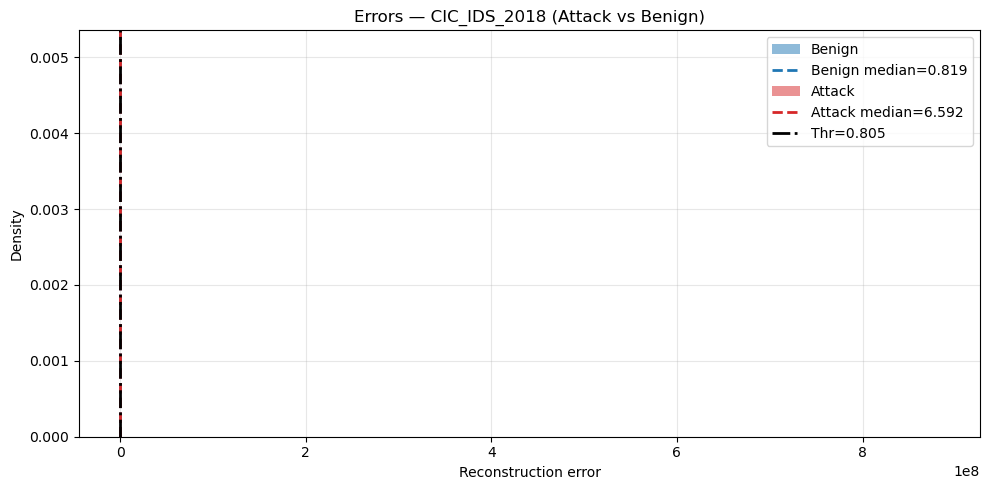

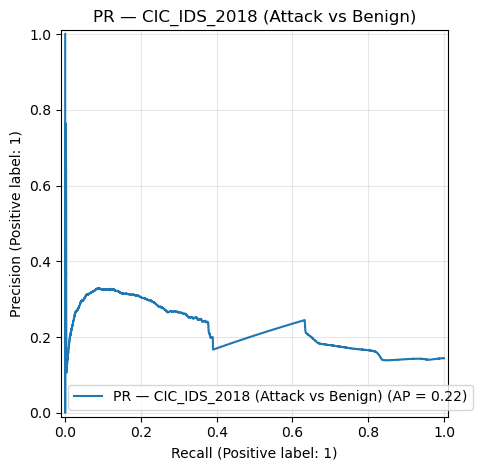

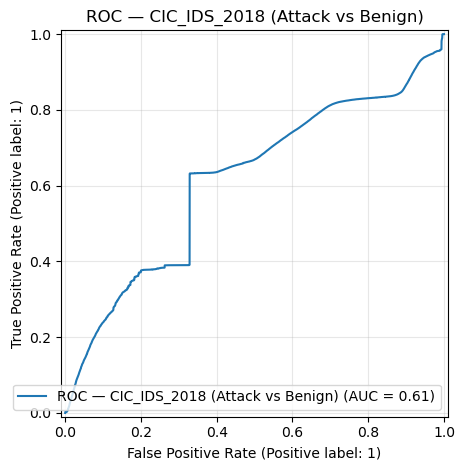

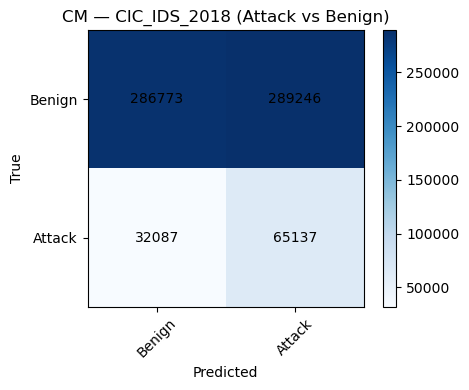

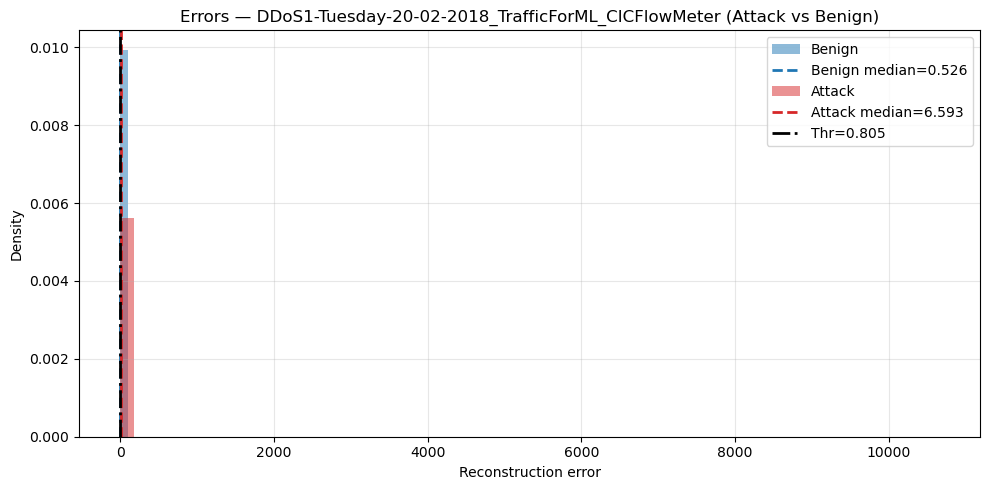

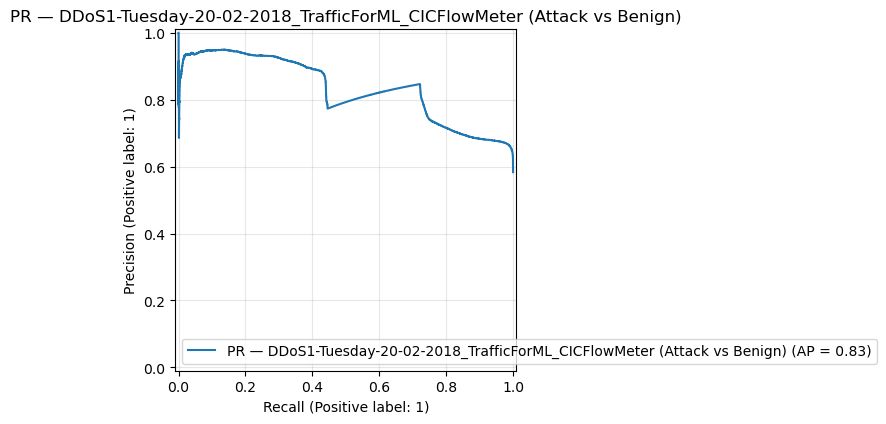

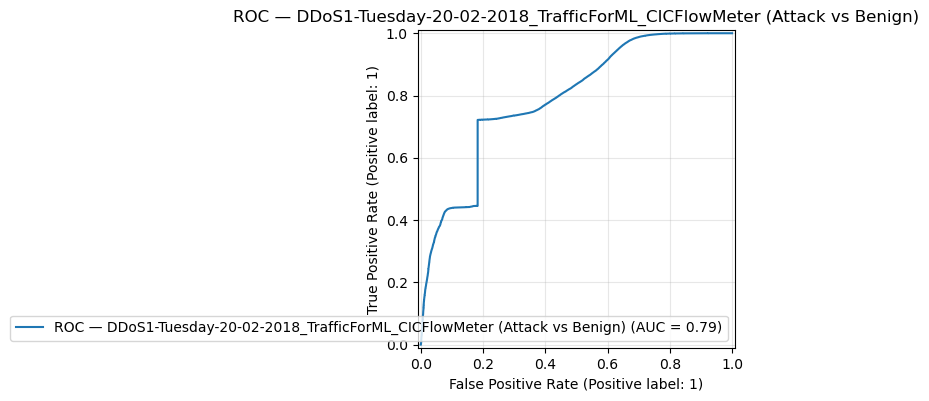

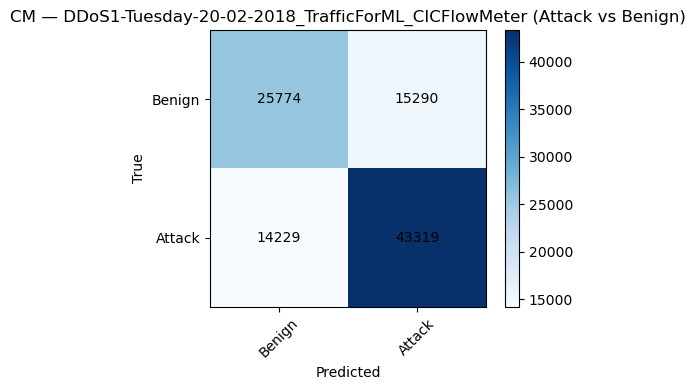

/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


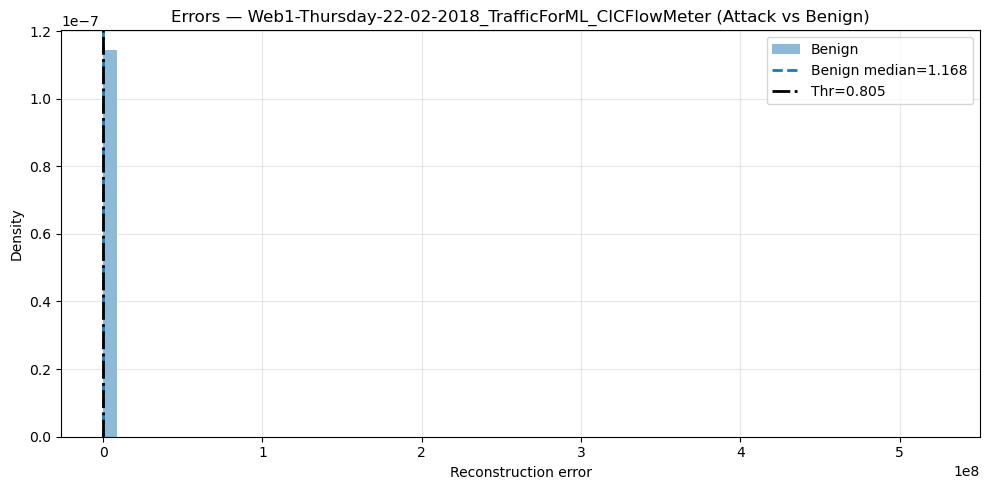

[VIS] PR — Web1-Thursday-22-02-2018_TrafficForML_CICFlowMeter (Attack vs Benign): single-class; PR skipped.
[VIS] ROC — Web1-Thursday-22-02-2018_TrafficForML_CICFlowMeter (Attack vs Benign): single-class; ROC skipped.


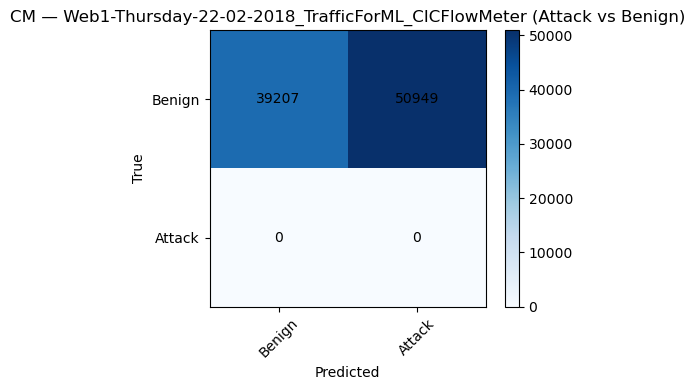

/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


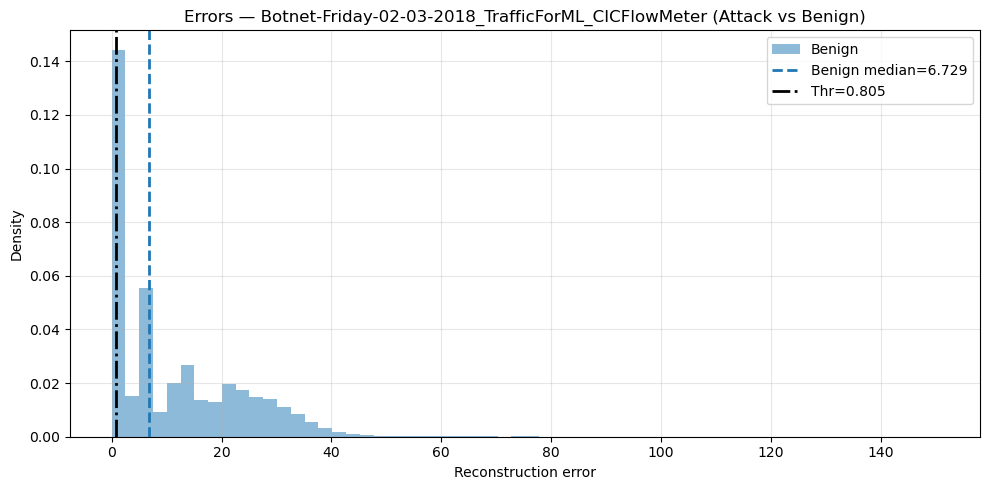

[VIS] PR — Botnet-Friday-02-03-2018_TrafficForML_CICFlowMeter (Attack vs Benign): single-class; PR skipped.
[VIS] ROC — Botnet-Friday-02-03-2018_TrafficForML_CICFlowMeter (Attack vs Benign): single-class; ROC skipped.


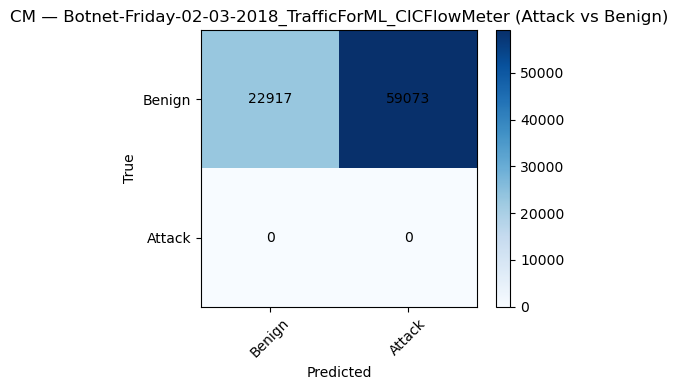

/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


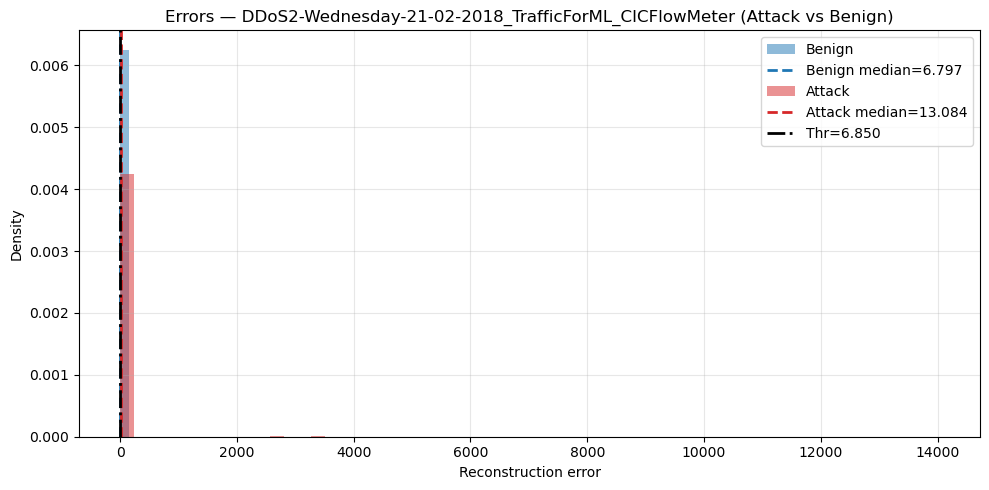

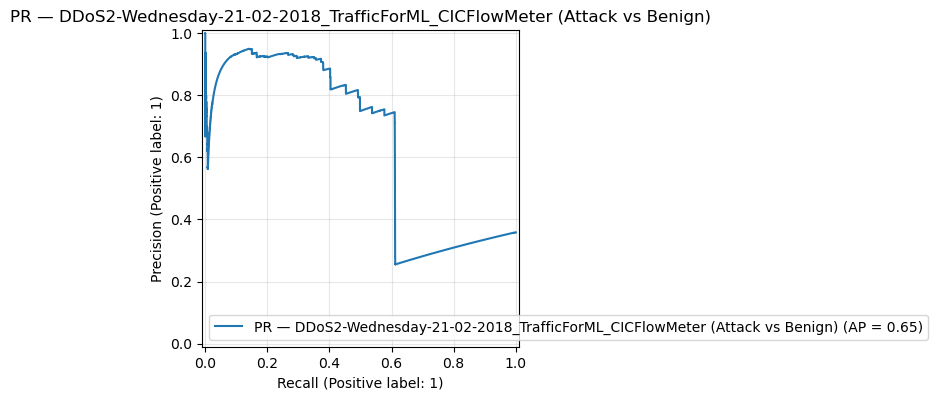

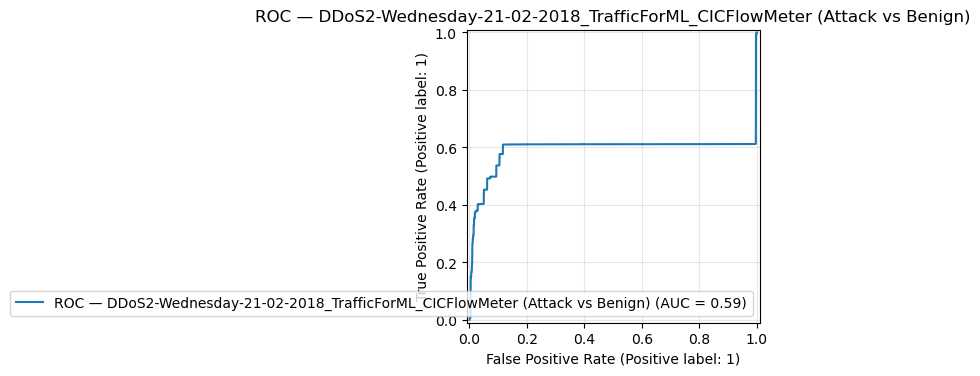

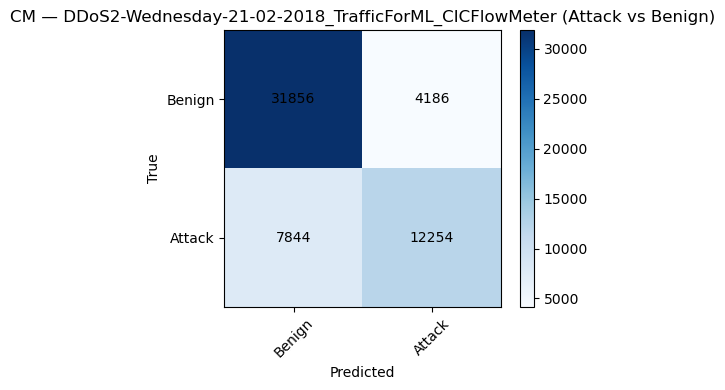

/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


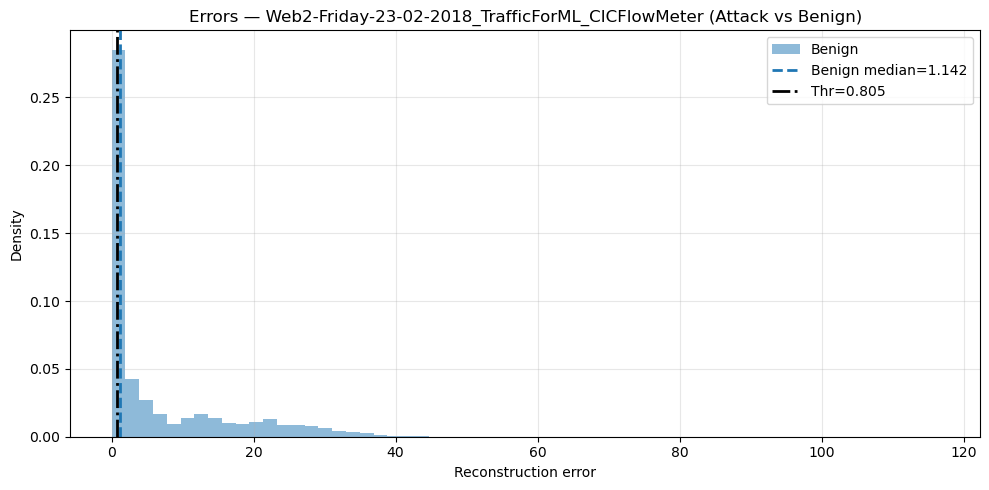

[VIS] PR — Web2-Friday-23-02-2018_TrafficForML_CICFlowMeter (Attack vs Benign): single-class; PR skipped.
[VIS] ROC — Web2-Friday-23-02-2018_TrafficForML_CICFlowMeter (Attack vs Benign): single-class; ROC skipped.


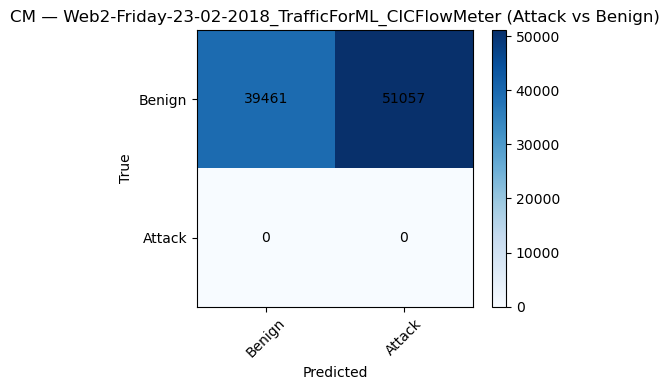

/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


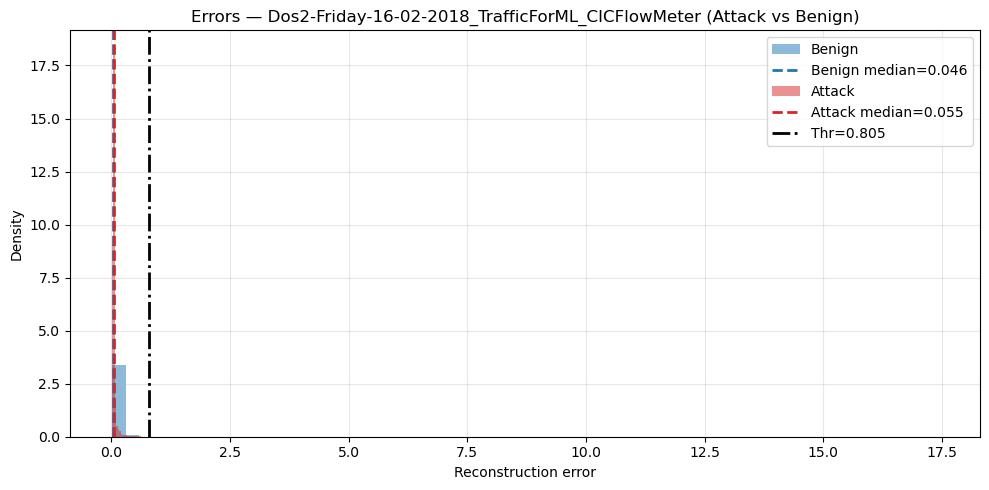

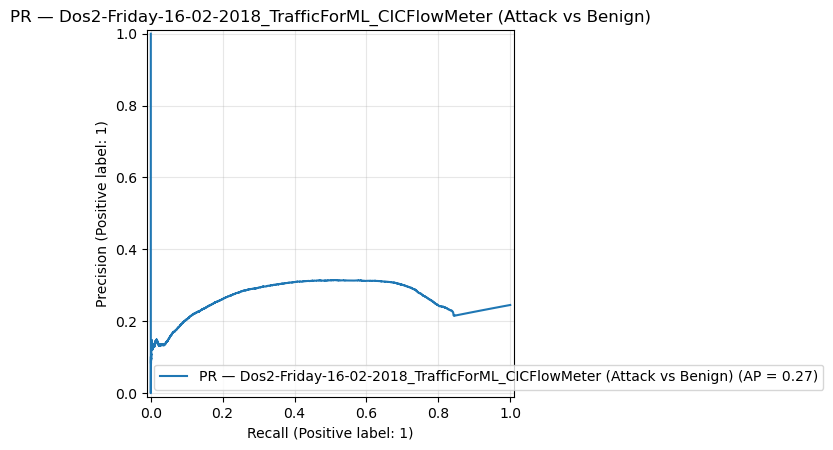

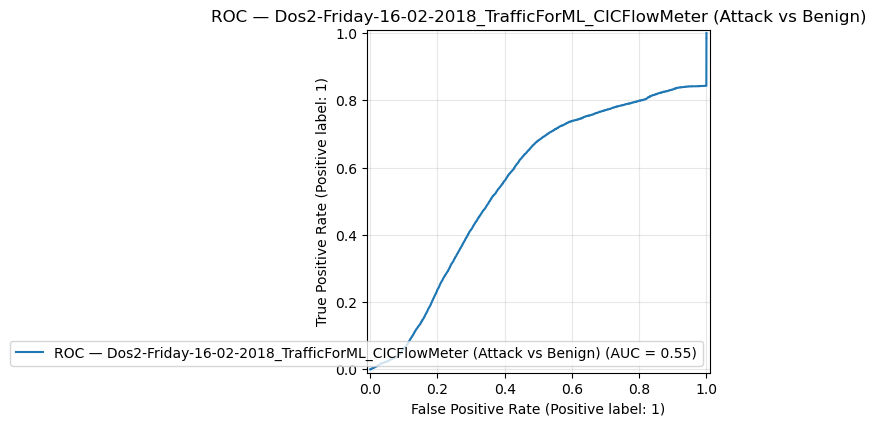

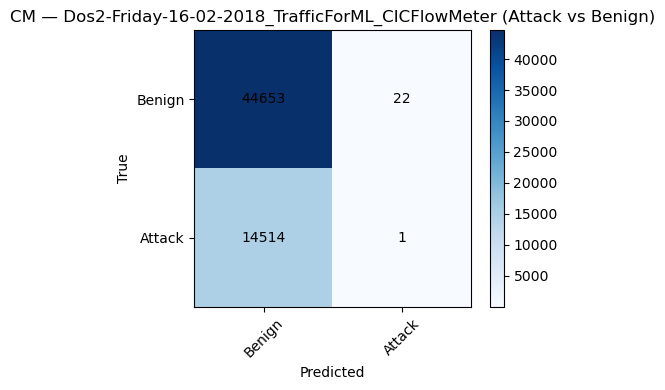

/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


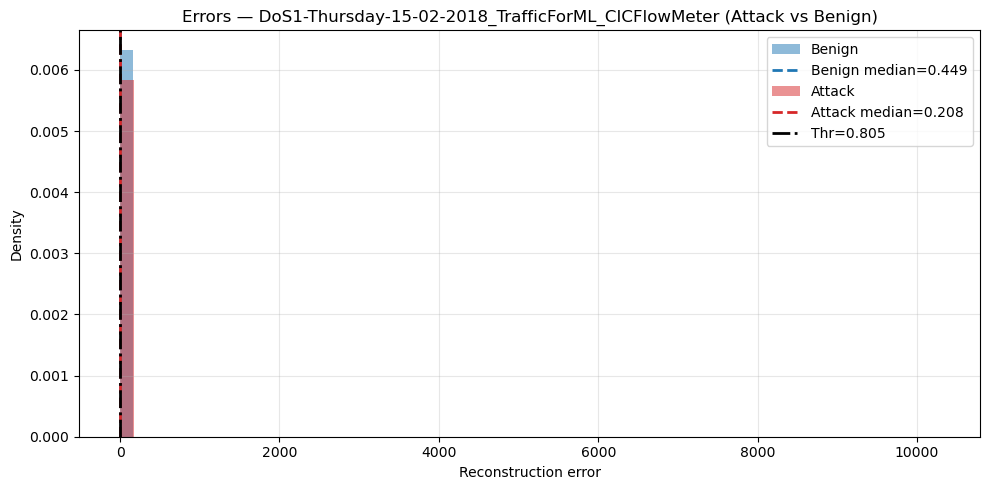

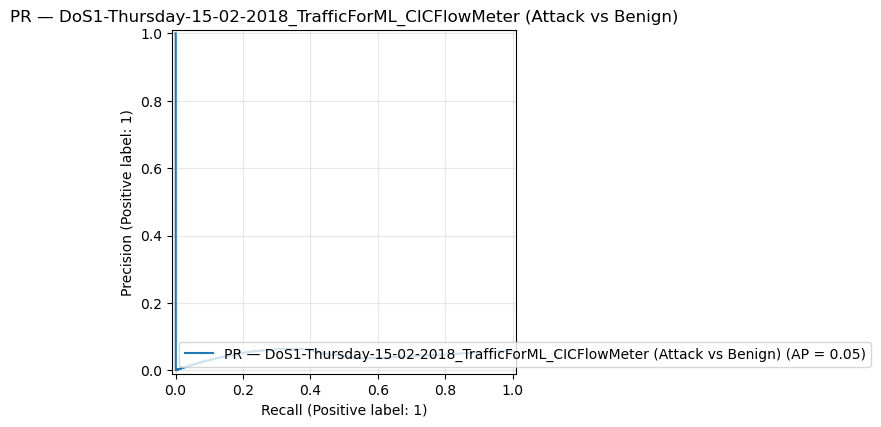

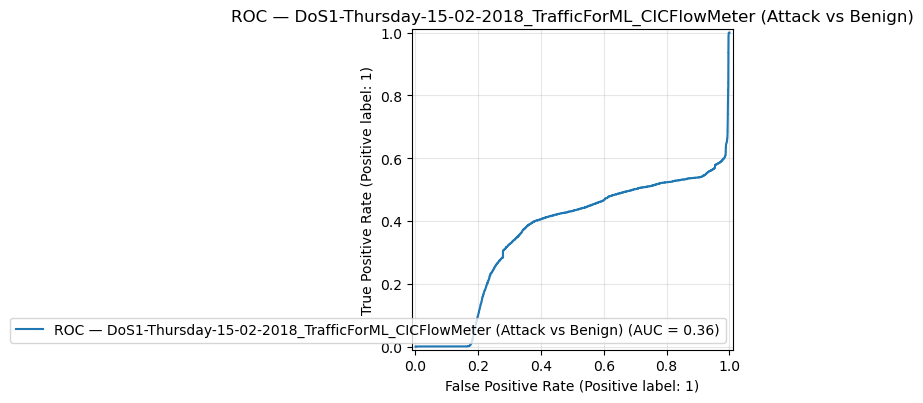

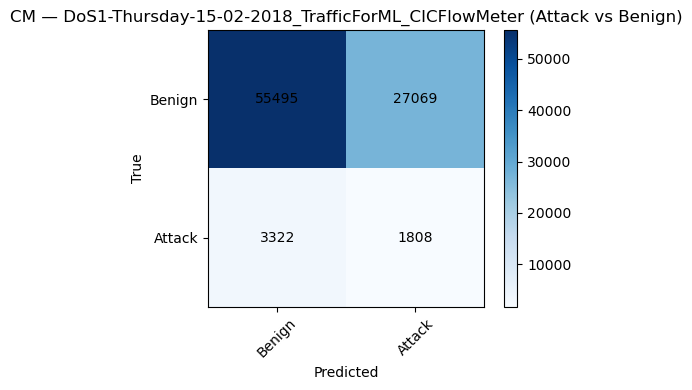

/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


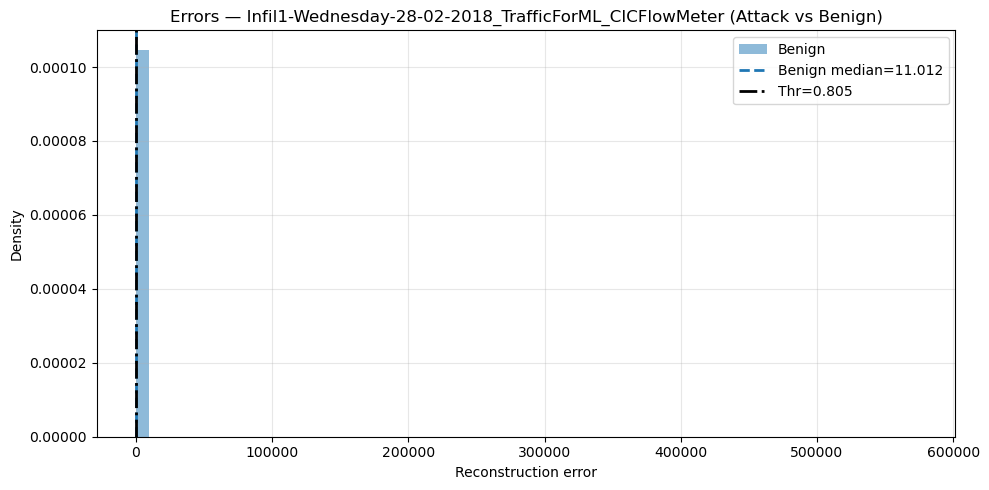

[VIS] PR — Infil1-Wednesday-28-02-2018_TrafficForML_CICFlowMeter (Attack vs Benign): single-class; PR skipped.
[VIS] ROC — Infil1-Wednesday-28-02-2018_TrafficForML_CICFlowMeter (Attack vs Benign): single-class; ROC skipped.


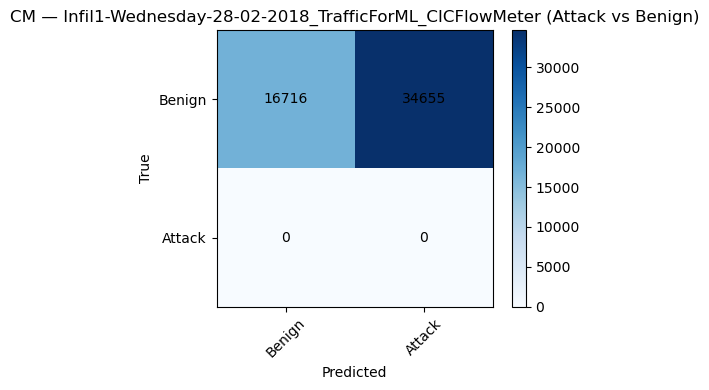

/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


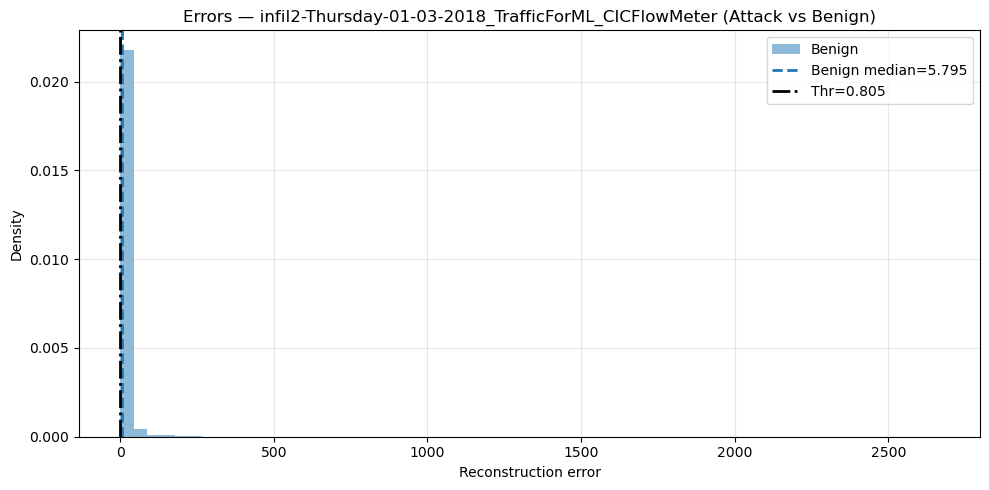

[VIS] PR — infil2-Thursday-01-03-2018_TrafficForML_CICFlowMeter (Attack vs Benign): single-class; PR skipped.
[VIS] ROC — infil2-Thursday-01-03-2018_TrafficForML_CICFlowMeter (Attack vs Benign): single-class; ROC skipped.


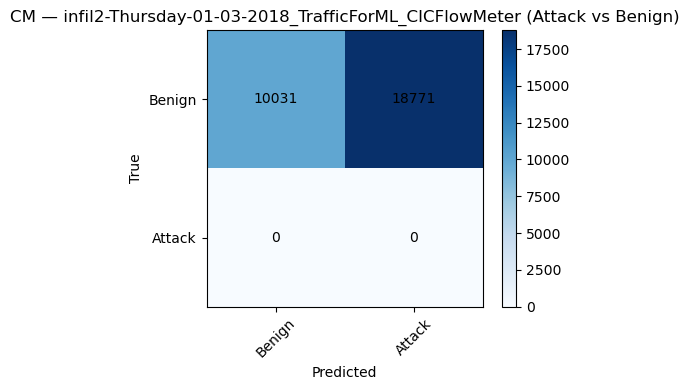

/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


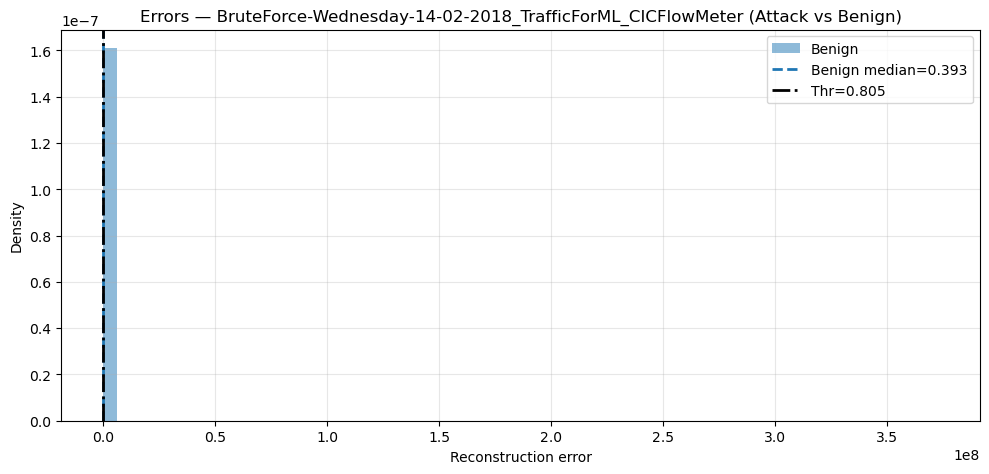

[VIS] PR — BruteForce-Wednesday-14-02-2018_TrafficForML_CICFlowMeter (Attack vs Benign): single-class; PR skipped.
[VIS] ROC — BruteForce-Wednesday-14-02-2018_TrafficForML_CICFlowMeter (Attack vs Benign): single-class; ROC skipped.


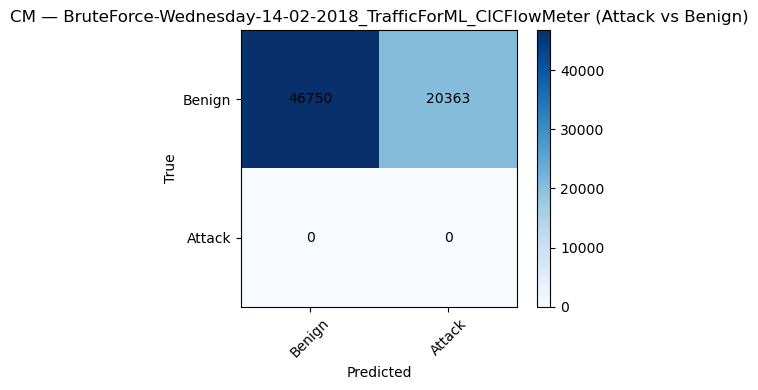

/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[INFO] Saved metrics JSON -> metrics.json

################################################################################
### AE-only: Train on CIC_IDS_2018  |  Test on CIC_IDS_2017
################################################################################
Train sequences: (673243, 10, 70), Test sequences: (246866, 10, 70)
[INFO] Training AE for 2018 (cfg: sl10_nf70_lat64_enc128_dec128) ...
Encoder LSTM 0 output shape: (batch, 10, 128)
Final Encoder output shape: (batch, 128)
Latent vector shape: (batch, 64)
After RepeatVector: (batch, 10, 64)
Decoder LSTM 0 output shape: (batch, 10, 128)
Reconstruction shape: (batch, 10, 70)
Model: "LSTM_AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 70)]          0         
                                                                 
 enc_lstm_0 (LSTM)           (None, 10, 128)           101888    
           

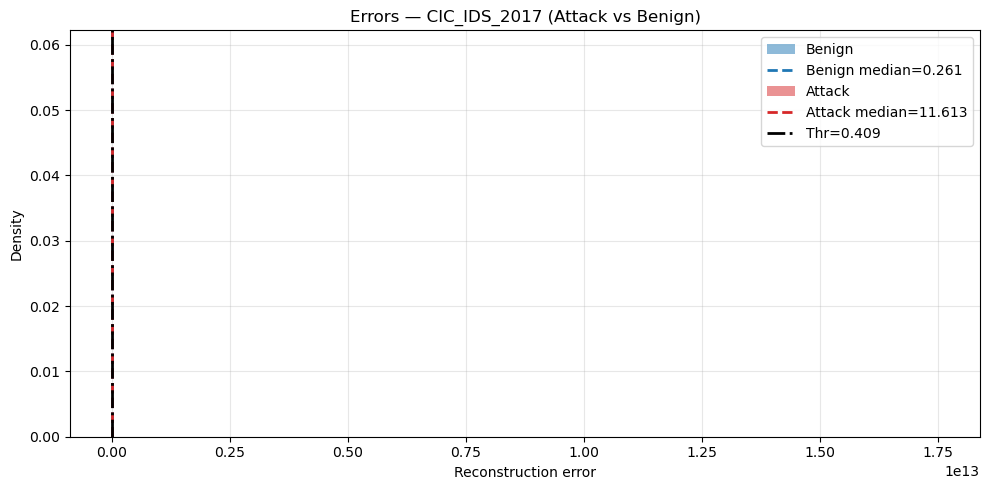

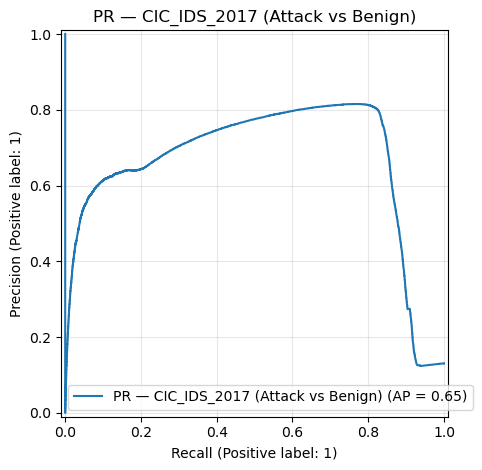

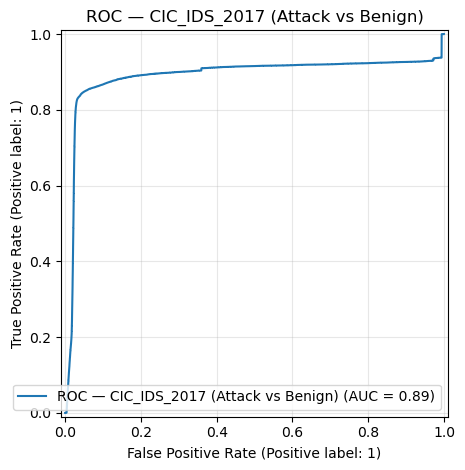

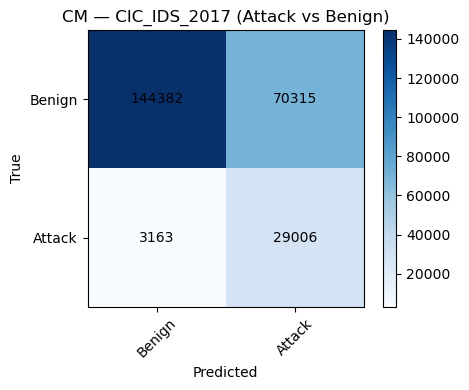

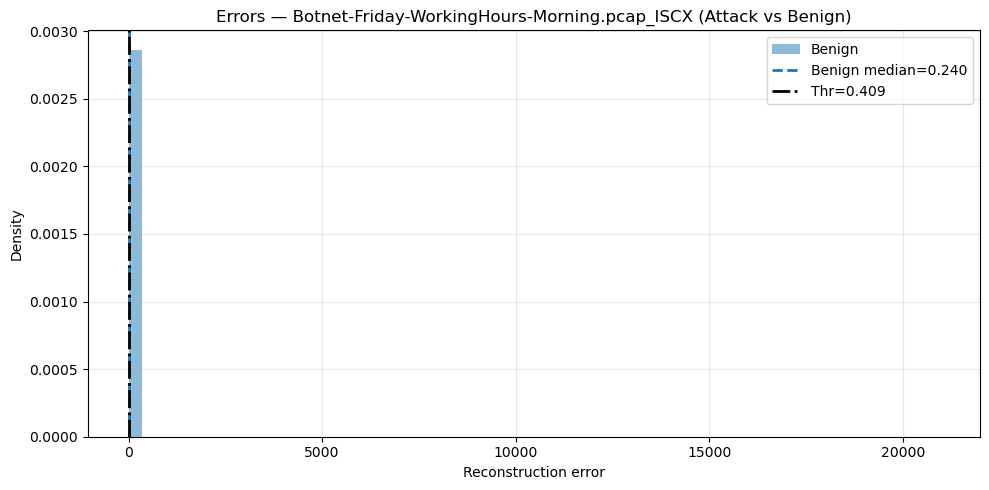

[VIS] PR — Botnet-Friday-WorkingHours-Morning.pcap_ISCX (Attack vs Benign): single-class; PR skipped.
[VIS] ROC — Botnet-Friday-WorkingHours-Morning.pcap_ISCX (Attack vs Benign): single-class; ROC skipped.


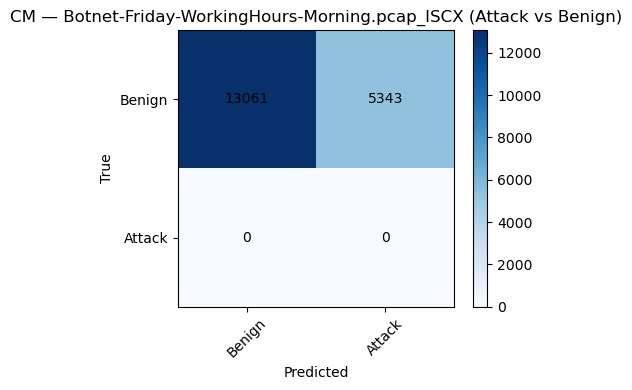

/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


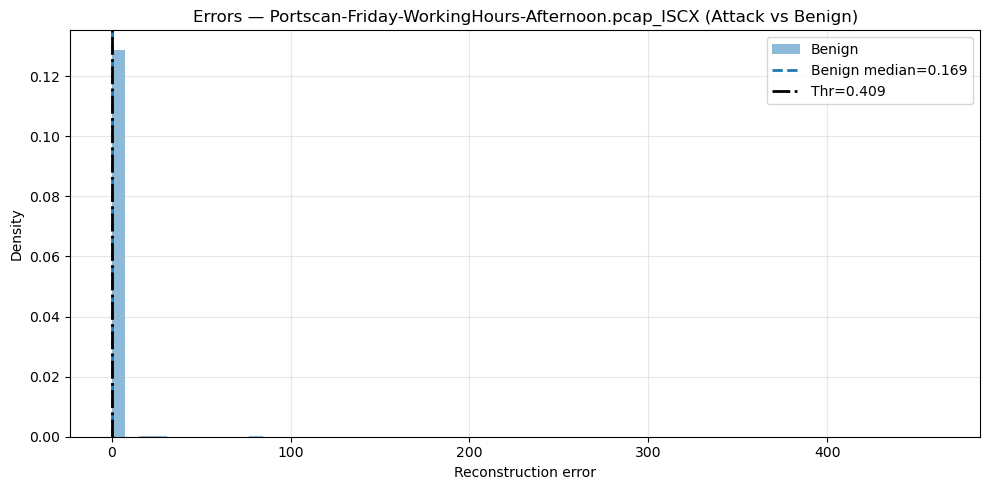

[VIS] PR — Portscan-Friday-WorkingHours-Afternoon.pcap_ISCX (Attack vs Benign): single-class; PR skipped.
[VIS] ROC — Portscan-Friday-WorkingHours-Afternoon.pcap_ISCX (Attack vs Benign): single-class; ROC skipped.


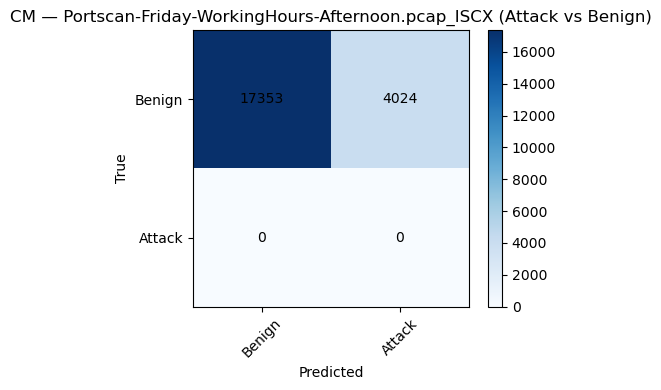

/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


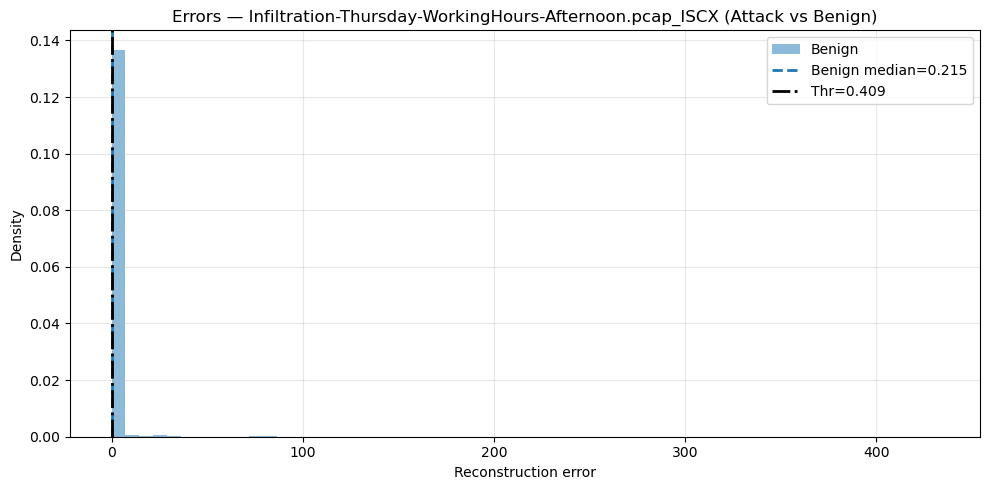

[VIS] PR — Infiltration-Thursday-WorkingHours-Afternoon.pcap_ISCX (Attack vs Benign): single-class; PR skipped.
[VIS] ROC — Infiltration-Thursday-WorkingHours-Afternoon.pcap_ISCX (Attack vs Benign): single-class; ROC skipped.


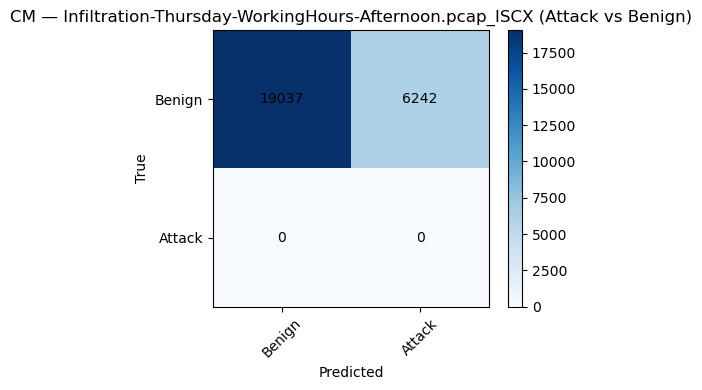

/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


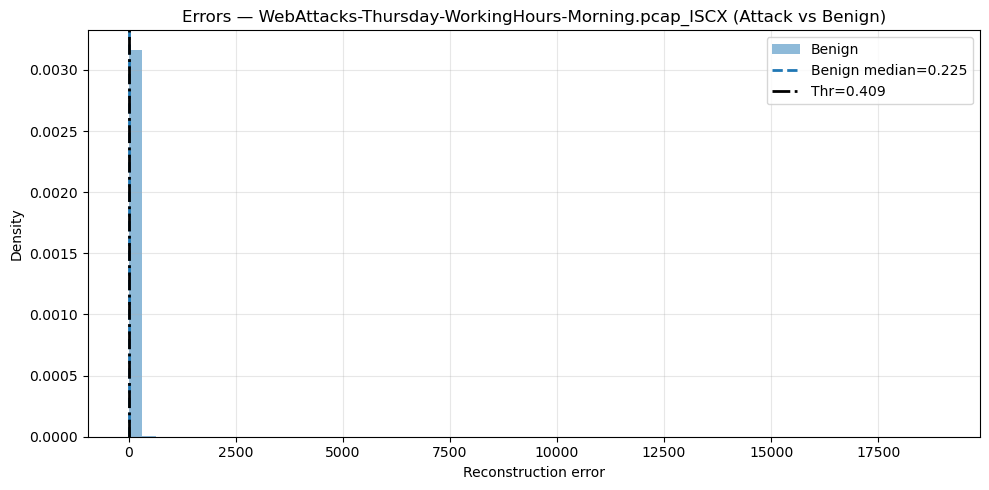

[VIS] PR — WebAttacks-Thursday-WorkingHours-Morning.pcap_ISCX (Attack vs Benign): single-class; PR skipped.
[VIS] ROC — WebAttacks-Thursday-WorkingHours-Morning.pcap_ISCX (Attack vs Benign): single-class; ROC skipped.


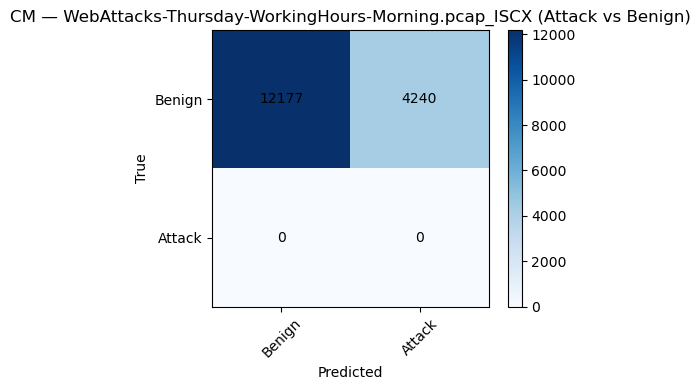

/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


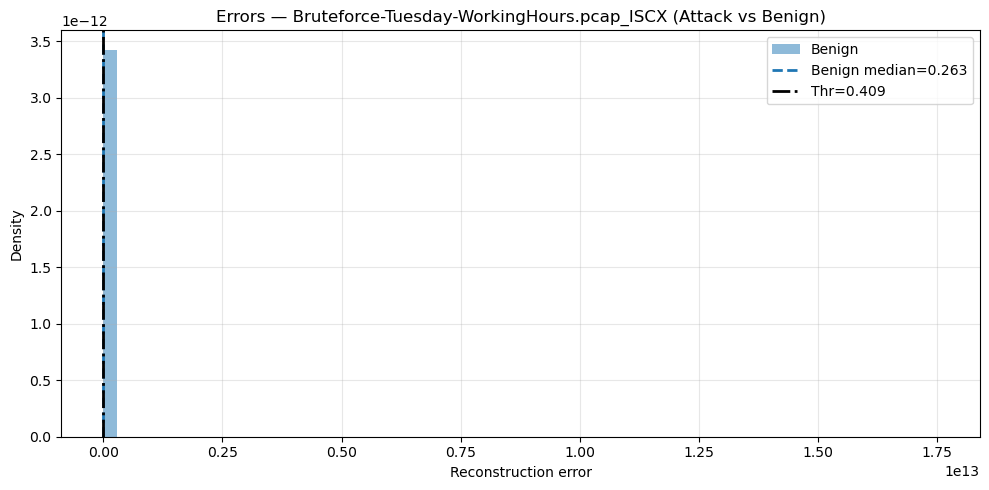

[VIS] PR — Bruteforce-Tuesday-WorkingHours.pcap_ISCX (Attack vs Benign): single-class; PR skipped.
[VIS] ROC — Bruteforce-Tuesday-WorkingHours.pcap_ISCX (Attack vs Benign): single-class; ROC skipped.


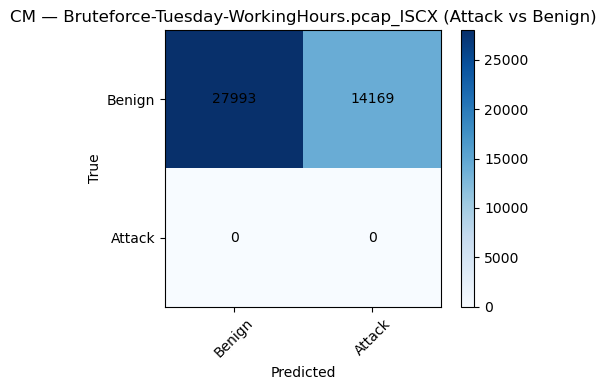

/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


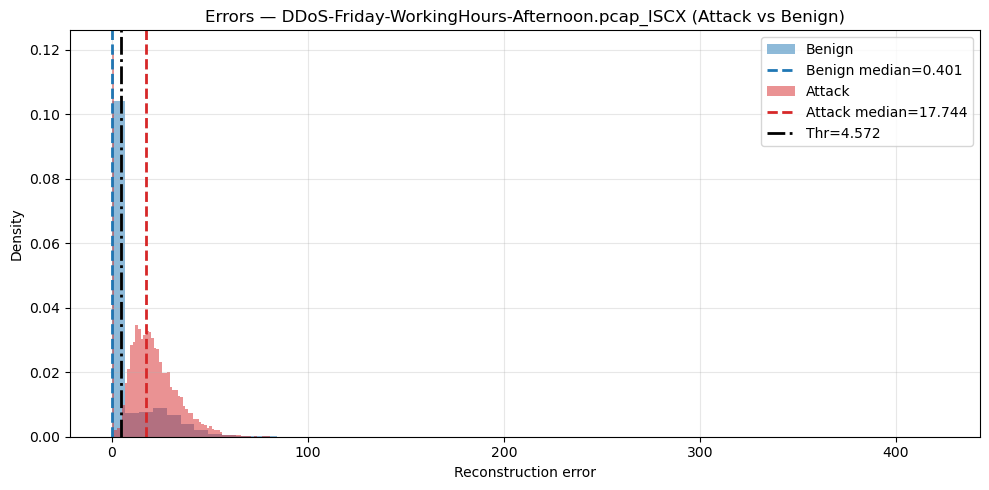

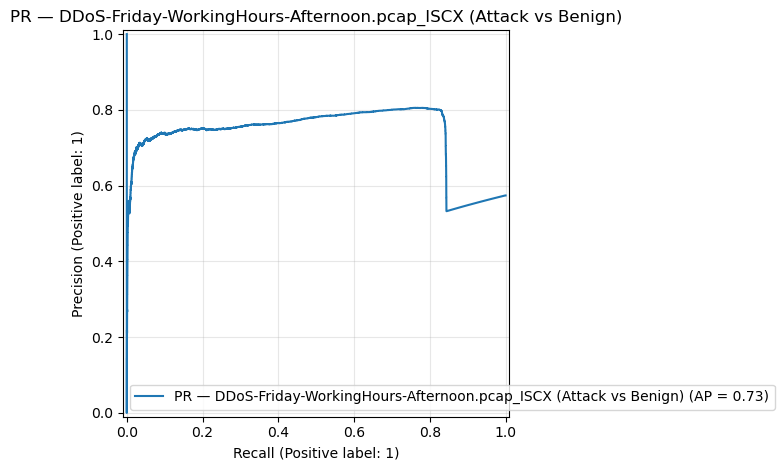

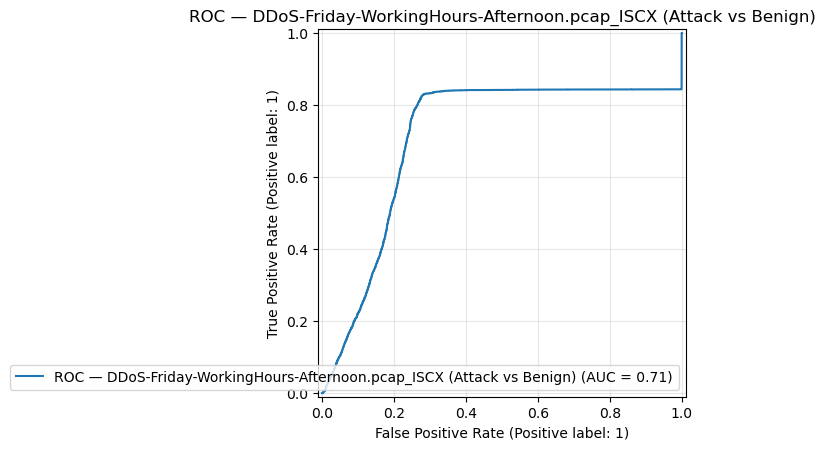

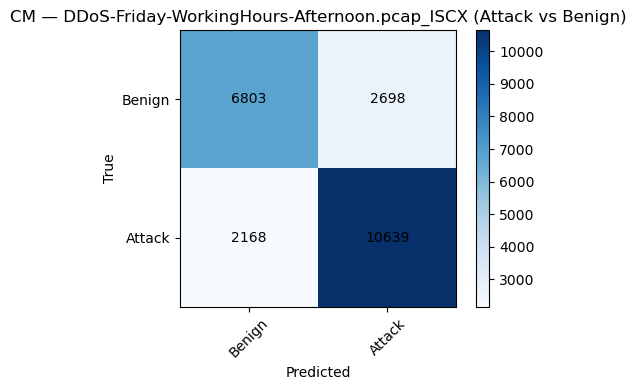

/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


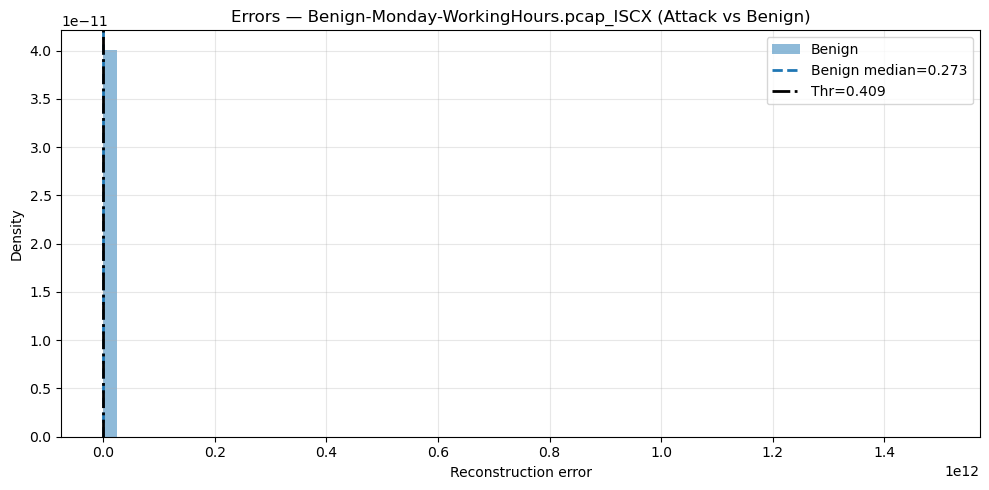

[VIS] PR — Benign-Monday-WorkingHours.pcap_ISCX (Attack vs Benign): single-class; PR skipped.
[VIS] ROC — Benign-Monday-WorkingHours.pcap_ISCX (Attack vs Benign): single-class; ROC skipped.


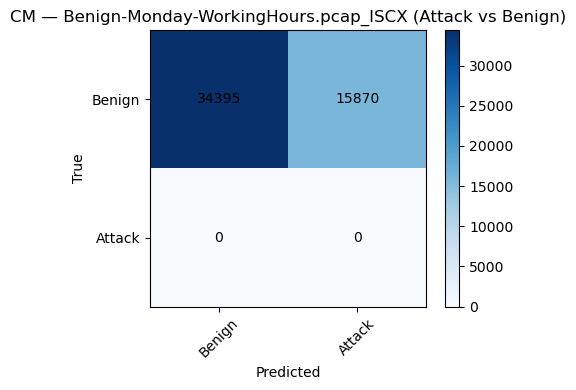

/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


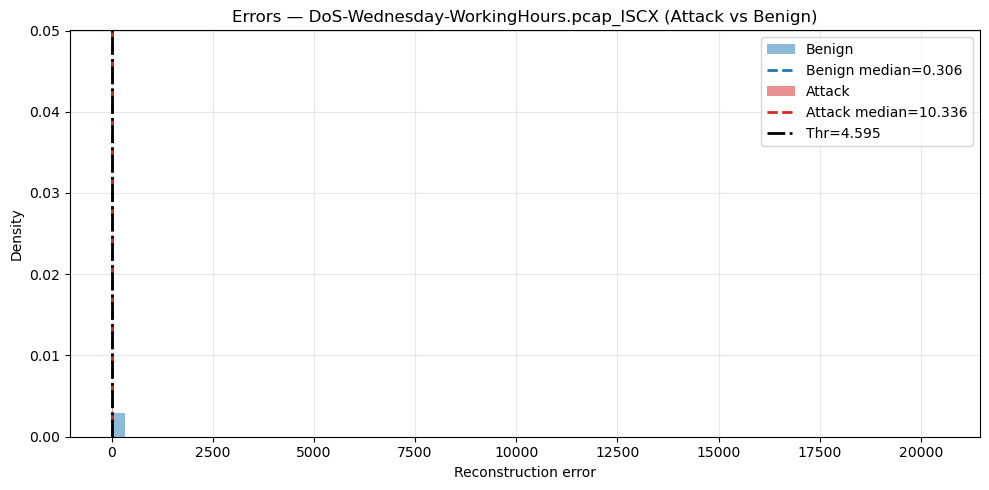

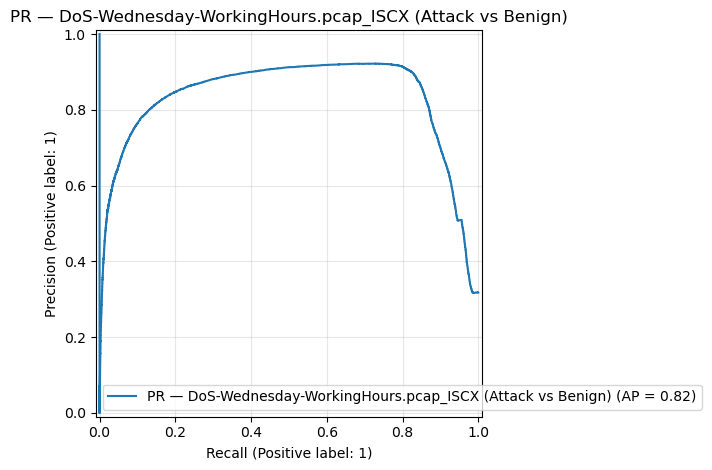

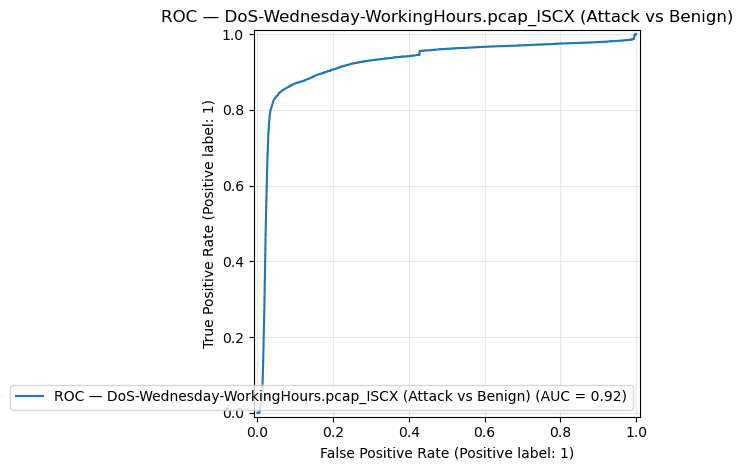

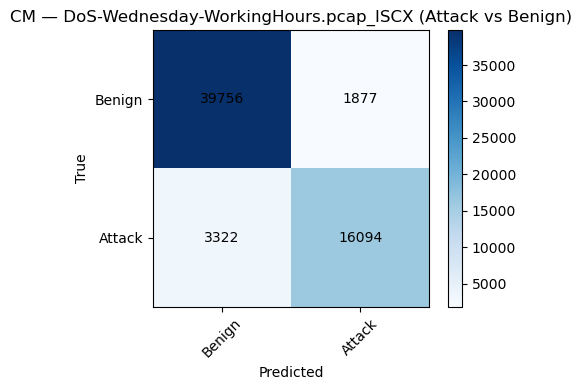

/Users/srinara2/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[INFO] Saved metrics JSON -> metrics.json
[INFO] Saved all scenarios JSON -> ae_results/all_scenarios_metrics.json

RESULTS  Train=CIC_IDS_2017  Test=CIC_IDS_2018
Accuracy: 0.5227  Precision: 0.1838  Recall: 0.6700  F1: 0.2885  ROC-AUC: 0.6118
Global Threshold used: 0.805462  CM: [[286773, 289246], [32087, 65137]]

--- Per-Day Metrics (AE-only, binary) ---

Day: DDoS1-Tuesday-20-02-2018_TrafficForML_CICFlowMeter
  Day Thr: 0.805462
  Overall -> Acc=0.7007  Prec=0.7391  Rec=0.7527  F1=0.7459  ROC-AUC=0.7911
             CM (rows=true [Benign,Attack], cols=pred): [[25774, 15290], [14229, 43319]]  Support: {'benign': 41064, 'attack': 57548}
  DoS     -> No positive support for DoS on this day (all Benign).
             CM (rows=true [Benign,DoS], cols=pred): [[40889, 175], [0, 0]]  Support: {'benign': 41064, 'DoS': 0}
  DDoS    -> Thr=0.805462  Acc=0.7007  Prec=0.7391  Rec=0.7527  F1=0.7459  ROC-AUC=0.7911
             CM (rows=true [Benign,DDoS], cols=pred): [[25774, 15290], [14229, 4331

In [9]:
def run_cross_ae_only(
        seq_len=20, stride=None, ae_epochs=10, batch_size=256, verbose=1, per_day=True,
        use_day_threshold=False, q_global=0.995,qlow_day=0.60,qhigh_day=0.99, per_attack_mode="max_f1",
        per_attack_target_precision=0.80,error_metric='mse', huber_delta=1.0, show_plots=True,k=6.0,build_lstm_autoencoder_fn=None):
    (
        all_combined_dfs,
        all_individual_dfs_by_dataset,
        _,
        _,
        common_features,
        broad_label_mapper,
        broad_label_encoder
    ) = load_and_align_all_data(DATASET_PATHS)

    tf.keras.utils.set_random_seed(42)
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
     
    if stride is None:
        stride = max(1, seq_len // 2)  # overlapping by default

    scenarios = [
        ("CIC_IDS_2017", "CIC_IDS_2018"),
        ("CIC_IDS_2018", "CIC_IDS_2017"),
    ]

    results = {}

    for train_name, test_name in scenarios:
        print("\n" + "#"*80)
        print(f"### AE-only: Train on {train_name}  |  Test on {test_name}")
        print("#"*80)

        train_df = all_combined_dfs[train_name]
        test_df  = all_combined_dfs[test_name]

        X_train_flat  = train_df[common_features].fillna(0.0).to_numpy(dtype=np.float32)
        y_train_flat  = train_df["BroadLabel"].astype(int).to_numpy()
        X_test_flat   = test_df[common_features].fillna(0.0).to_numpy(dtype=np.float32)
        y_test_flat   = test_df["BroadLabel"].astype(int).to_numpy()

        benign_id = broad_label_encoder.transform(["Benign"])[0]
        dos_id    = broad_label_encoder.transform(["DoS"])[0]
        ddos_id   = broad_label_encoder.transform(["DDoS"])[0]
        allowed_labels = {benign_id, dos_id, ddos_id}

        # Filter to Benign/DoS/DDoS
        train_mask = np.isin(y_train_flat, list(allowed_labels))
        X_train_flat, y_train_flat = X_train_flat[train_mask], y_train_flat[train_mask]
        test_mask = np.isin(y_test_flat, list(allowed_labels))
        X_test_flat,  y_test_flat  = X_test_flat[test_mask], y_test_flat[test_mask]

        scaler = StandardScaler()
        X_train_flat = scaler.fit_transform(X_train_flat).astype(np.float32)
        X_test_flat  = scaler.transform(X_test_flat).astype(np.float32)

        X_train_seq, y_train_seq = build_sequences_matrix(X_train_flat, y_train_flat, seq_len=seq_len, stride=stride)
        X_test_seq,  y_test_seq  = build_sequences_matrix(X_test_flat,  y_test_flat,  seq_len=seq_len, stride=stride)
        print(f"Train sequences: {X_train_seq.shape}, Test sequences: {X_test_seq.shape}")

        # Stage 1: AE on Benign-only
        X_ae = X_train_seq[y_train_seq == benign_id]
        X_ae_tr, X_ae_val = time_ordered_split(X_ae, val_ratio=0.1)

        seq_len_eff = X_train_seq.shape[1]
        n_features  = X_train_seq.shape[2]
        ae, encoder, history = train_or_load_ae(
            X_train_seq=X_ae_tr,
            seq_len=seq_len_eff,
            n_features=n_features,
            train_name=train_name,
            ae_epochs=ae_epochs,
            batch_size=batch_size,
            verbose=verbose,
            latent=64,
            enc_units=(128,),
            dec_units=(128,),
            models_dir="lstmmodels",
            loss_fn='mse',
           
            compile_loaded=False,
            X_val_seq=X_ae_val,
            shuffle_fit=False,
            build_lstm_autoencoder_fn=build_lstm_autoencoder
        )

        # GLOBAL threshold from TRAIN benign errors and overall threshold
        benign_train_errors = compute_recon_error(ae, X_ae_tr,metric=error_metric,huber_delta=huber_delta) if X_ae_tr.size else np.array([])
        thr_global = choose_threshold_global(benign_train_errors, q=q_global, k=k)
        print(f"[INFO] Global AE threshold (q={q_global}, k={k}): {thr_global:.6f}")

        # Overall test: binary detection Attack vs Benign using AE error
        err_test = compute_recon_error(ae, X_test_seq,metric=error_metric,huber_delta=huber_delta)
        y_true_attack = np.isin(y_test_seq, [dos_id, ddos_id]).astype(int)  # 1=Attack, 0=Benign


        thr_used = thr_global # overall report uses global (keep simple)

        y_pred_attack = (err_test > thr_used).astype(int)

        acc = accuracy_score(y_true_attack, y_pred_attack)
        p, r, f1, _ = precision_recall_fscore_support(y_true_attack, y_pred_attack, average='binary', zero_division=0)


        try:
            has_ben = (y_true_attack == 0).any()
            has_att = (y_true_attack == 1).any()
            roc = roc_auc_score(y_true_attack, err_test) if (has_ben and has_att) else np.nan
        except Exception:
            roc = np.nan
        cm = confusion_matrix(y_true_attack, y_pred_attack, labels=[0,1])


        print(f"\n--- Overall AE-only (binary) on {test_name} ---")
        print(f"Accuracy={acc:.4f}  Precision={p:.4f}  Recall={r:.4f}  F1={f1:.4f}  ROC-AUC={roc:.4f}")
        cm = confusion_matrix(y_true_attack, y_pred_attack, labels=[0,1])
        print("Confusion matrix (rows=true [Benign,Attack], cols=pred):")
        print(cm)

        # Optional overall plots
        if show_plots:
            err_ben_overall = err_test[y_true_attack == 0]
            err_att_overall = err_test[y_true_attack == 1]
            plot_error_hist(err_ben_overall, err_att_overall, thr=thr_used,
                            title=f"Errors — {test_name} (Attack vs Benign)")
            plot_pr(err_test, y_true_attack, title=f"PR — {test_name} (Attack vs Benign)")
            plot_roc(err_test, y_true_attack, title=f"ROC — {test_name} (Attack vs Benign)")
            plot_confmat(cm, labels=["Benign","Attack"], title=f"CM — {test_name} (Attack vs Benign)")


        results[(train_name, test_name)] = {
            "overall_binary": {
                "accuracy": acc, "precision": p, "recall": r, "f1": f1, "roc_auc": roc,
                "threshold": thr_used, "cm": cm.tolist()
            }
        }

        # Per-day evaluation (binary)
        if per_day:
            per_day_metrics = {}
            indiv = all_individual_dfs_by_dataset[test_name]
            for day_name, df_day in indiv.items():
                if df_day.empty: 
                    continue
                    
                Xd = df_day[common_features].fillna(0.0).to_numpy(dtype=np.float32)
                yd = df_day["BroadLabel"].astype(int).to_numpy()
                Xd = scaler.transform(Xd).astype(np.float32)
                Xd_seq, yd_seq = build_sequences_matrix(Xd, yd, seq_len=seq_len, stride=stride)
                if len(yd_seq) == 0:
                    continue

                # AE errors
                err_day = compute_recon_error(ae, Xd_seq)
                # Overall day binary labels
                y_true_day_overall = np.isin(yd_seq, [dos_id, ddos_id]).astype(int)
                
                if use_day_threshold:
                    thr_day_raw = choose_day_threshold_by_pr(
                        err_day, y_true_day_overall, fallback_thr=thr_used, mode="max_f1"
                    )
                else:
                    thr_day_raw = thr_used


                
                # Per-attack (DoS / DDoS) binary reports with attack-specific thresholds
                thr_day_cap = float(np.quantile(err_day, 0.98)) if err_day.size else thr_day  # 98th pct of day


                thr_day = max(thr_day_raw, thr_used)

                y_pred_day_overall = (err_day > thr_day).astype(int)
                accd = accuracy_score(y_true_day_overall, y_pred_day_overall)
                pd_, rd_, f1d, _ = precision_recall_fscore_support(
                    y_true_day_overall, y_pred_day_overall, average='binary', zero_division=0
                )
                try:
                    has_ben = (y_true_day_overall == 0).any()
                    has_att = (y_true_day_overall == 1).any()
                    rocd = roc_auc_score(y_true_day_overall, err_day) if (has_ben and has_att) else np.nan
                except Exception:
                    rocd = np.nan
                cm_day = confusion_matrix(y_true_day_overall, y_pred_day_overall, labels=[0,1])


                # Optional per-day overall plots
                if show_plots:
                    # --- Per-day visuals (overall binary) ---
                    err_ben_day = err_day[y_true_day_overall == 0]
                    err_att_day = err_day[y_true_day_overall == 1]
                     # Error histogram with day threshold
                    plot_error_hist(err_ben_day, err_att_day, thr=thr_day, title=f"Errors — {day_name} (Attack vs Benign)")
                    # PR & ROC (guarded for single-class internally)
                    plot_pr(err_day, y_true_day_overall, title=f"PR — {day_name} (Attack vs Benign)")
                    plot_roc(err_day, y_true_day_overall, title=f"ROC — {day_name} (Attack vs Benign)")
                    # Confusion matrix heatmap
                    plot_confmat(cm_day, labels=["Benign","Attack"], title=f"CM — {day_name} (Attack vs Benign)")



 



                per_attack = {}
                for attack_name, attack_id in [("DoS", dos_id), ("DDoS", ddos_id)]:
                    mask = np.isin(yd_seq, [benign_id, attack_id])
                    if not mask.any():
                        continue
                     
                    # Compute per-attack labels on the subset
                    y_true_sub = (yd_seq[mask] == attack_id).astype(int)

                    if attack_name == "DoS":
                        metric_for_attack = "huber"
                        err_sub = compute_recon_error(ae, Xd_seq[mask], metric='huber', huber_delta=0.5)
                    else:
                        metric_for_attack = "mse"
                        err_sub = compute_recon_error(ae, Xd_seq[mask], metric='mse')
                    # Benign-only errors in this subset for a benign-anchored cap
                    ben_mask_sub = (y_true_sub == 0)
                    if ben_mask_sub.any():
                        ben_err = err_sub[ben_mask_sub]
                        med_b  = float(np.median(ben_err))
                        mad_b  = float(np.median(np.abs(ben_err - med_b)) * 1.4826)
                        thr_brob = med_b + k * mad_b                 # robust benign cap
                        thr_bq   = float(np.quantile(ben_err, 0.995))# high benign quantile cap
                        thr_bcap = min(thr_brob, thr_bq)
                    else:
                        # If no benign in the subset (odd, but safe fallback)
                        thr_bcap = thr_day_cap

                
                    # Choose raw threshold from PR curve
                    if attack_name == "DoS":
                        # Stricter: target precision to control FPs
                        thr_sub_raw = choose_subset_thr(
                            err_sub, y_true_sub, fallback_thr=thr_day,
                            mode="target_precision", target_p=per_attack_target_precision
                        )
                        # Optional safety: if this drives recall to ~0 in practice, fallback:
                        if thr_sub_raw is None:
                            thr_sub_raw = thr_max_f1(err_sub, y_true_sub)  # balanced fallback
                    else:
                        # Balanced for DDoS
                        thr_sub_raw = choose_subset_thr(
                            err_sub, y_true_sub, fallback_thr=thr_day,
                            mode="max_f1"
                        )

                    # Final clamp to: [global_floor, min(day_cap, benign_cap)]
                    upper_cap = min(thr_day_cap, thr_bcap)
                    thr_sub   = max(thr_used, min(thr_sub_raw, upper_cap, float(err_sub.max())))

                    y_pred_sub = (err_sub > thr_sub).astype(int)

                    # Compute metrics guarded for single-class subsets
                    has_ben_sub = (y_true_sub == 0).any()
                    has_att_sub = (y_true_sub == 1).any()
                    acc_sub = accuracy_score(y_true_sub, y_pred_sub) if (has_ben_sub or has_att_sub) else np.nan
                    if has_ben_sub or has_att_sub:
                        prec_sub, rec_sub, f1_sub, _ = precision_recall_fscore_support(
                            y_true_sub, y_pred_sub, average='binary', zero_division=0
                        )
                        try:
                            roc_sub = roc_auc_score(y_true_sub, err_sub)
                        except Exception:
                            roc_sub = np.nan
                    else:
                        prec_sub, rec_sub, f1_sub, roc_sub = (np.nan, np.nan, np.nan, np.nan)

                    cm_sub = confusion_matrix(y_true_sub, y_pred_sub, labels=[0, 1])


                    # # Optional per-attack visuals
                    # if show_plots:
                    #     # Error histogram on the subset with threshold
                    #     eb = err_sub[y_true_sub == 0]
                    #     ea = err_sub[y_true_sub == 1]
                    #     plot_error_hist(eb, ea, thr=thr_sub, title=f"Errors — {day_name} ({attack_name})")
                    #     # PR/ROC (skip if single-class)
                    #     plot_pr(err_sub, y_true_sub, title=f"PR — {day_name} ({attack_name})")
                    #     plot_roc(err_sub, y_true_sub, title=f"ROC — {day_name} ({attack_name})")
                    #     # Confusion matrix for the subset
                    #     plot_confmat(cm_sub, labels=["Benign", attack_name], title=f"CM — {day_name} ({attack_name})")


  

                    per_attack[attack_name] = {
                        "metric_used": metric_for_attack,
                        "threshold": float(thr_sub),                # NEW alias (clamped)
                        "threshold_raw": float(thr_sub_raw),
                        "threshold_clamped": float(thr_sub),
                        "caps": {
                            "day_cap_98pct": float(thr_day_cap),
                            "benign_cap": float(thr_bcap)
                        },
                        "accuracy": acc_sub,
                        "precision": prec_sub,
                        "recall": rec_sub,
                        "f1": f1_sub,
                        "roc_auc": roc_sub,
                        "cm": cm_sub.tolist(),
                        "support": {
                            "benign": int((y_true_sub == 0).sum()),
                            attack_name: int((y_true_sub == 1).sum())
                        }
                    }

                # Store per-day metrics
                 
                per_day_metrics[day_name] = {
                    "threshold": thr_day,
                    "overall_binary": {
                        "accuracy": accd, "precision": pd_, "recall": rd_, "f1": f1d,
                        "roc_auc": rocd, "cm": cm_day.tolist(),
                        "support": {
                            "benign": int((y_true_day_overall == 0).sum()),
                            "attack": int((y_true_day_overall == 1).sum())
                        }
                    },
                    "per_attack_binary": per_attack
                }   

            results[(train_name, test_name)]["per_day_binary"] = per_day_metrics
        save_dir = os.path.join("ae_results", f"{train_name}to{test_name}")
        save_json(results[(train_name, test_name)], os.path.join(save_dir, "metrics.json"))
        print(f"[INFO] Saved metrics JSON -> {'metrics.json'}")
        # Cleanup
        del ae, encoder, X_train_seq, X_test_seq, X_train_flat, X_test_flat, X_ae, X_ae_tr, X_ae_val
        gc.collect()
        tf.keras.backend.clear_session()
    return results

 
# ------------------------------------------------------------
# 5) Run (AE-only) — printing per-day DoS/DDoS binary reports
# ------------------------------------------------------------
if __name__ == "__main__":
    out = run_cross_ae_only(
        seq_len=10,
        stride=10,              # try 5 for overlap
        ae_epochs=10,
        batch_size=256,
        verbose=1,
        per_day=True,
        use_day_threshold=True,
        q_global=0.995,
        qlow_day=0.60,
        qhigh_day=0.99,
        k=6.0,
        per_attack_mode="max_f1",
        per_attack_target_precision=0.60,
        build_lstm_autoencoder_fn=build_lstm_autoencoder 
    )


    save_json(out, os.path.join("ae_results", "all_scenarios_metrics.json"))
    print("[INFO] Saved all scenarios JSON -> ae_results/all_scenarios_metrics.json")

    # Pretty print overall AE-only (binary) metrics
    for (tr, te), res in out.items():
        ov = res["overall_binary"]
        print("\n" + "="*80)
        print(f"RESULTS  Train={tr}  Test={te}")
        print(f"Accuracy: {ov['accuracy']:.4f}  Precision: {ov['precision']:.4f}  Recall: {ov['recall']:.4f}  F1: {ov['f1']:.4f}  ROC-AUC: {ov['roc_auc']:.4f}")
        print(f"Global Threshold used: {ov['threshold']:.6f}  CM: {ov['cm']}")

        # Per-day AE-only (binary) metrics, including per-attack reports
        if "per_day_binary" in res:
            print("\n--- Per-Day Metrics (AE-only, binary) ---")
            for day, m in res["per_day_binary"].items():
                print(f"\nDay: {day}")
                print(f"  Day Thr: {m['threshold']:.6f}")
                o = m["overall_binary"]
                roc_str = f"{o['roc_auc']:.4f}" if not np.isnan(o['roc_auc']) else "N/A"
                print(f"  Overall -> Acc={o['accuracy']:.4f}  Prec={o['precision']:.4f}  Rec={o['recall']:.4f}  F1={o['f1']:.4f}  ROC-AUC={roc_str}")
                print(f"             CM (rows=true [Benign,Attack], cols=pred): {o['cm']}  Support: {o['support']}")
                for atk_name, a in m.get("per_attack_binary", {}).items():
                    sup_b = a['support']['benign']
                    sup_a = a['support'][atk_name]
                    if sup_b > 0 and sup_a > 0 and not np.isnan(a['accuracy']):
                        roc_a_str = f"{a['roc_auc']:.4f}" if not np.isnan(a['roc_auc']) else "N/A"
                        print(f"  {atk_name:<7} -> Thr={a['threshold']:.6f}  Acc={a['accuracy']:.4f}  Prec={a['precision']:.4f}  Rec={a['recall']:.4f}  F1={a['f1']:.4f}  ROC-AUC={roc_a_str}")
                        print(f"             CM (rows=true [Benign,{atk_name}], cols=pred): {a['cm']}  Support: {a['support']}")
                    else:
                        if sup_a == 0 and sup_b > 0:
                            print(f"  {atk_name:<7} -> No positive support for {atk_name} on this day (all Benign).")
                            print(f"             CM (rows=true [Benign,{atk_name}], cols=pred): {a['cm']}  Support: {a['support']}")
                        elif sup_b == 0 and sup_a > 0:
                            print(f"  {atk_name:<7} -> No Benign support on this day (all {atk_name}).")
                            print(f"             CM (rows=true [Benign,{atk_name}], cols=pred): {a['cm']}  Support: {a['support']}")
                        else:
                            print(f"  {atk_name:<7} -> Single-class subset; metrics/ROC-AUC not defined.")
                            print(f"             CM (rows=true [Benign,{atk_name}], cols=pred): {a['cm']}  Support: {a['support']}")



